In [1]:
# Imports
from IPython.display import display, HTML

def setup_display(width=95, fontsize=16):
    """
    Sets window width and markdown fontsize for Jupyter notebook. Width is % of window.
    """
    display(HTML("<style>.container { width:"+str(width)+"% !important; }</style>"))
    display(HTML("<style>.rendered_html { font-size: "+str(fontsize)+"px; }</style>"))
    return None

def source(fn):
    import inspect
    print(inspect.getsource(fn))
    return None

import numpy as np
import glob
import winnie
from winnie.plot import animate_quick_implot, quick_implot, mpl, plt
from spaceKLIP import database
import webbpsf
import astropy.units as u

plt.style.use('winnie.winnie_mplstyle') # Comment this out or replace it if you prefer a different plot style

setup_display()

In [2]:
# Prep the SpaceRDI object:
distance = 9.714 # Distance to your target in parsecs

base_dir = './aumic_rdi_example/'
input_dir = f'{base_dir}coadded/'
output_dir = f'{base_dir}WinnieRDI/'
data_ext = 'calints'
fitsfiles = np.sort(glob.glob(f'{input_dir}*{data_ext}.fits')) # Populate a file list

# Initialize the spaceKLIP database
Database = database.Database(output_dir)
Database.verbose = False
Database.read_jwst_s012_data(datapaths=fitsfiles)

# Create the SpaceRDI object we'll use to carry out RDI
wdb = winnie.SpaceRDI(Database, data_ext, overwrite=True, verbose=True, pad_data='auto')

The prepare_convolution method in the next cell should only be executed if you need to PSF-convolve models at some point. 

Note: you can also run this after loading your first concatenation. However, it only needs to be run once for a given winnie.SpaceRDI object.

A few details to keep in mind:

- Your PSF grid parameters — fov_pixels, nr (the number of radial grid samples), and ntheta (the number of azimuthal grid samples) — will matter a lot more for disks with flux near or across the IWA region — like an edge-on disk. 

- For a ring-like disk that's moderately inclined, settings like fov_pixels\~100, nr\~5, ntheta=4, should be sufficient and will speed up your forward modeling.

- For scattered light (~ NIRCam), generating PSFs using a spectrum comparable to that of the science target star should be a reasonable approximation.

- For thermal emission (~ MIRI), you may want to use something like a blackbody approximating the temperature of the disk.

In [3]:
# Spectrum to assume for the convolution PSFs; ck04 doesn't have an M1, so we're just using an M0V instead.
spec_synphot = webbpsf.specFromSpectralType('M0V', catalog='ck04')

wdb.prepare_convolution(spec_synphot, fov_pixels=201, osamp=2, grid_kwargs=dict(nr=10, ntheta=4))

In [4]:
# The first time loading each concatenation will take ~5-10 minutes for generating the PSF grid. Reloading later, it should be much quicker.
wdb.load_concat(0)

# Run a basic RDI reduction with default settings.
rdi_reduc = wdb.run_rdi()

JWST_NIRCAM_NRCALONG_F356W_MASKRND_MASK335R_SUB320A335R
Science data:   2 exposures of shape (429,430)
Reference data: 6 exposures of shape (429,430)

RDI Settings:
Extension for output files: 'rdi_psfsub'
1 optimization zone(s)
1 subtraction zone(s)
Setting up sim to match ./aumic_rdi_example/coadded/jw01184001001_03107_00001_nrcalong_calints.fits

MAST OPD query around UTC: 2022-10-03T06:25:46.792
                        MJD: 59855.267902685184

OPD immediately preceding the given datetime:
	URI:	 mast:JWST/product/O2022100201-NRCA3_FP1-1.fits
	Date (MJD):	 59854.1754
	Delta time:	 -1.0925 days

OPD immediately following the given datetime:
	URI:	 mast:JWST/product/O2022100401-NRCA3_FP1-1.fits
	Date (MJD):	 59856.3241
	Delta time:	 1.0562 days
User requested choosing OPD time closest in time to 2022-10-03T06:25:46.792, which is O2022100401-NRCA3_FP1-1.fits, delta time 1.056 days
Importing and format-converting OPD from /Users/kdlawso1/jwst/data/webbpsf_data/MAST_JWST_WSS_OPDs/O202210

  0%|          | 0/41 [00:00<?, ?it/s]

# PSF grid convolution and forward modeling:

In [5]:
# Disk modeling functions and imports
from scipy import ndimage
from winnie.utils import px_size_to_ang_size, ang_size_to_proj_sep, median_filter_sequence
import vip_hci as vip
from vip_hci.fm import ScatteredLightDisk, Phase_function
from astropy import convolution
from IPython.display import clear_output

def grater_2hg_disk_model(r0, h0, ain, aout, pa, incl, g1, g2, wg1,
                           e=0., omega=0., gamma=2., beta=1.,
                           cent=np.array([160.,160.]),
                           distance=10., nx=320, ny=320,
                           pxscale=0.063*u.arcsec/u.pixel, 
                           accuracy=None, rmax_accuracy=None,
                           halfNbSlices=25, polar=False, flux_max=None):
    """
    A simple ring-like disk morphology based on Augereau et al. (1999) and assuming a linear combo of two H-G SPFs as the scattering phase function.
    
    r0: fiducial radius in au
    h0: technically h0/r0 — the ratio of scale height to fiducial radius at the fiducial radius
    ain: radial density power law exponent interior to r0
    aout: radial density power law exponent exterior to r0
    pa: disk position angle in degrees
    incl: disk inclination in degrees
    g1: 1st Henyey-Greenstein asymmetry parameter
    g2: 2nd Henyey-Greenstein asymmetry parameter
    wg1: Weight for the SPF term with asymmetry parameter g1 (value in range 0-1); wg2 is 1-wg1
    e: eccentricity
    omega: argument of pericenter in degrees
    gamma: vertical density exponent (gamma = 2 for gaussian)
    beta: disk radial flaring exponent (beta = 1 for linear)
    
    cent: the pixel position for the center of the disk (generally the location of the star in the data)
    distance: distance to the target in parsecs
    nx: number of x-axis pixels for the image
    ny: number of y-axis pixels for the image
    pxscale: the pixel scale for the data; either a float (must be arcsec/pixel) or astropy units (any units that can be cast to arcsec/pixel)
    accuracy: the numerical accuracy for the model; pixels with density below this value will be set to zero
    rmax_accuracy: if accuracy is None, the model's accuracy is set such that non-zero values are achieved to this separation (in au)
    halfNbSlices: the number of planar slices to compute above and below the disk midplane
    polar: if True, a simple bell-shaped polarization curve is used to generate a polarized intensity image
    flux_max: if not None, normalize the model image so that this is the maximum value.
    """
    
    def dont_actually_check_inclination():
        """
        VIP's ScatteredLightDisk will normally decrease disk inclination if too high.
        This will cause issues for optimization, so we'd rather live with the artifacts / etc.
        Instead, we just tell VIP that the incl is good whenever it checks.
        """
        return None
 
    if accuracy is None:
        if rmax_accuracy is None:
            im_corner_dists = np.hypot(*(np.array([[0, 0], [0, ny-1], [nx-1, 0], [nx-1, ny-1]])-cent).T)
            rmax_accuracy = ang_size_to_proj_sep(px_size_to_ang_size(np.max(im_corner_dists), pxscale), distance).value
        accuracy = (rmax_accuracy/r0)**(aout)
            
    spf = {'name':'DoubleHG', 'g': [g1, g2], 'weight': wg1, 'polar': polar}
    dens = {'name': '2PowerLaws', 'ain': ain, 'aout': aout, 'a': r0, 'ksi0':h0*r0,
            'e': e, 'gamma': gamma, 'beta': beta, 'accuracy': accuracy}
    
    vip_disk = ScatteredLightDisk(nx=nx, ny=ny, distance=distance,
                                  itilt=incl, pxInArcsec=(pxscale << u.arcsec/u.pixel).value,
                                  pa=pa-180., omega=omega,
                                  density_dico=dens, spf_dico=spf, flux_max=flux_max)
    
    vip_disk.dust_density.accuracy = accuracy
    vip_disk.dust_density.dust_distribution_calc.rmax = vip_disk.dust_density.dust_distribution_calc.a*accuracy**(1/vip_disk.dust_density.dust_distribution_calc.aout)
    vip_disk.check_inclination = dont_actually_check_inclination
    disk = vip_disk.compute_scattered_light(halfNbSlices=halfNbSlices)

    # For disks with material coincident with the stellar position along the line of sight, VIP returns an image with a plus-sign shaped region of zeros at the star's position
    # The below is a quick work-around to correct this. Very likely makes zero difference following PSF-convolution
    c_vip = vip.var.frame_center(disk)[::-1]
    disk[c_vip[1]-1:c_vip[1]+2, c_vip[0]] = np.nan
    disk[c_vip[1], c_vip[0]-1:c_vip[0]+2] = np.nan
    disk = convolution.interpolate_replace_nans(disk, np.ones((3,3)))
    dx, dy = cent[0]-c_vip[0], cent[1]-c_vip[1]
    if dx != 0 or dy != 0:
        disk = ndimage.shift(disk, [dy, dx], order=5)
    return disk

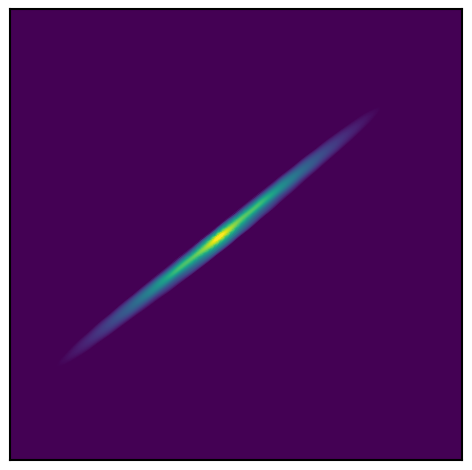

In [6]:
# Disk parameters (see grater_2hg_disk_model docstring)
# These are just some quick guesses to get something resembling what we actually see
r0, h0, ain, aout, pa, incl = 31.5, 0.035, 5, -5, 128.7, 89.2
g1, g2, wg1 = 0.85, -0.2, 0.75

raw_model = grater_2hg_disk_model(r0, h0, ain, aout, pa, incl, g1, g2, wg1,
                                  cent=wdb.c_star, distance=distance,
                                  nx=wdb.nx, ny=wdb.ny, pxscale=wdb.pxscale,
                                  flux_max=1080.)

quick_implot(raw_model, norm=mpl.colors.LogNorm, norm_kwargs=dict(clip=True), clim='0.00001*99.99%, 99.99%')

For the models in this notebook: we actually generate the models at detector sampling (**not** oversampled), and then subpixellate them before convolution. From my testing, this has no impact on fidelity after convolution and is much faster than generating the models at the oversampled resolution. However, I can't promise that this will be the case for every target.

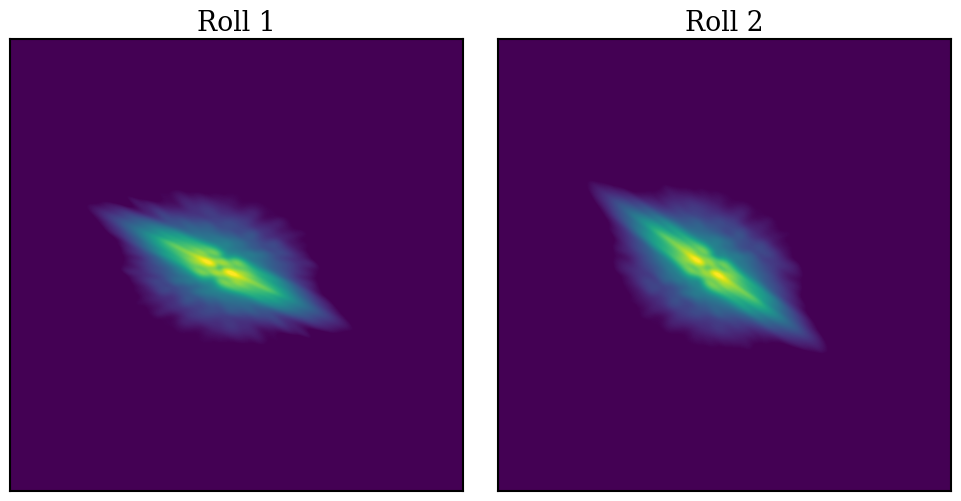

In [7]:
# Resample our raw model (if needed), rotate it to the position angles of the observations, multiply it by the coronagraph transmission map for each roll,
# and then convolve our raw model with the previously generated PSF grid:

model_cube = wdb.convolver.convolve_model(raw_model, wdb.pxscale, wdb.c_star)

fig,axes = quick_implot(model_cube, norm=mpl.colors.LogNorm, norm_kwargs=dict(clip=True), clim='0.001*99.99%, 99.99%', show=False)

for i, ax in enumerate(axes):
    ax.set_title(f'Roll {i+1}')
    
plt.show()

In [8]:
# Set the resulting model_cube as our circumstellar scene (CSS) model in the Winnie SpaceRDI object

wdb.set_circumstellar_model(model_cube=model_cube)

Note: you can also skip a step above by passing the raw model directly into wdb.set_circumstellar_model, which will then convolve it for you.

```
wdb.set_circumstellar_model(raw_model=raw_model, raw_model_pxscale=wdb.pxscale, raw_model_center=wdb.c_star)
```

Once the CSS model is set, we can do two big things with it.

First, we can forward model it for the current RDI configuration simply by setting forward_model=True in run_rdi:

In [9]:
fmrdi_reduc = wdb.run_rdi(forward_model=True)

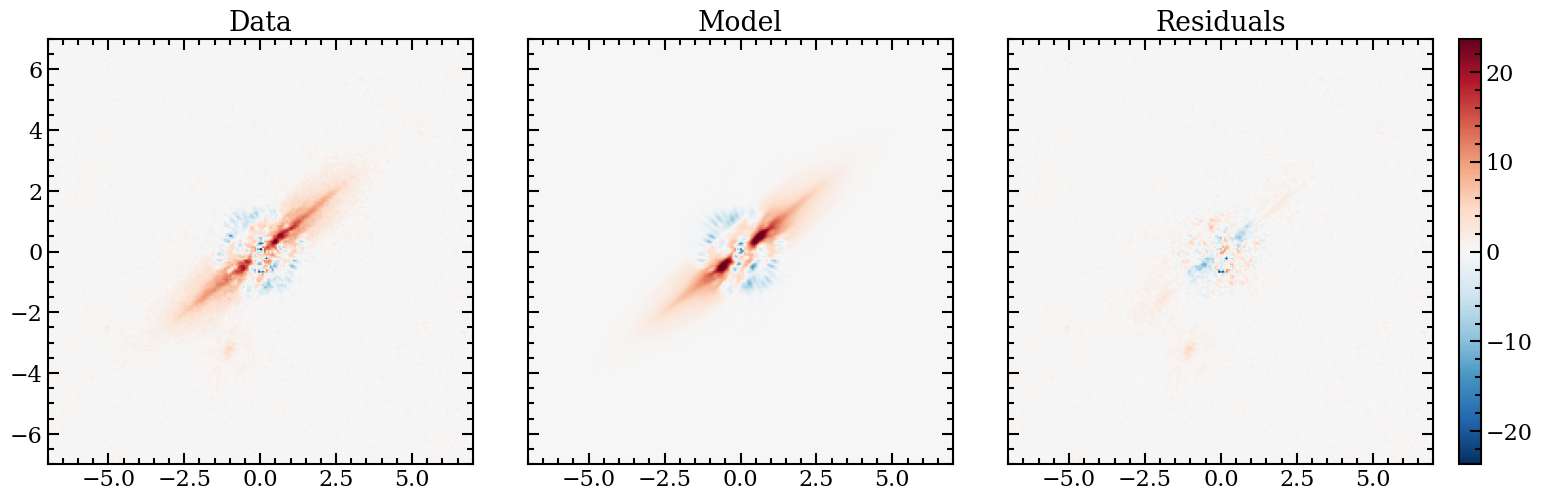

In [10]:
# Plot data, model, and residuals
fig,axes,cbar = quick_implot([rdi_reduc.im, fmrdi_reduc.im, rdi_reduc.im-fmrdi_reduc.im], cmap='RdBu_r', clim_perc=99.99, show=False,
                             cbar=True, cbar_kwargs=dict(pad=0.015), panelsize=(6,5), extent=rdi_reduc.extent, lims=[-7,7], show_ticks=True)

labels = ['Data', 'Model', 'Residuals']
for i,ax in enumerate(axes):
    ax.set_title(labels[i])

Second, we can run Model Constrained RDI by changing our PSF-subtraction presets and then executing run_rdi again:

In [11]:
wdb.mcrdi_presets() # This effectively asks Winnie to use the currently set circumstellar model to mitigate oversubtraction. See: tutorial 3 for more info

mcrdi_reduc = wdb.run_rdi()

# For comparison, let's derotate and average our model cube (this shows us the PSF-convolved model without any PSF-subtraction effects --- i.e., 100% algorithmic throughput)
model_reduc = wdb.derotate_and_combine_circumstellar_model()

JWST_NIRCAM_NRCALONG_F356W_MASKRND_MASK335R_SUB320A335R
Science data:   2 exposures of shape (429,430)
Reference data: 6 exposures of shape (429,430)

RDI Settings:
'hcube_css': <class 'numpy.ndarray'> of shape (2, 1, 429, 430)
Extension for output files: 'mcrdi_psfsub'
1 optimization zone(s)
1 subtraction zone(s)


Note: technically we could forward model our disk model with the MCRDI reduction settings like we did for RDI. E.g.,

```
wdb.mcrdi_presets()
mcrdi_reduc = wdb.run_rdi()
fmmcrdi_reduc = wdb.run_rdi(forward_model=True)
```

However, the results will be the same as for ```wdb.derotate_and_combine_circumstellar_model()```

MCRDI is effectively an inversion of the forward modeling procedure. As such, while we can technically apply forward modeling in the typical framework, it's mathematically circular and doesn't provide any information. 

You can see this in the plots below, where the residuals panels are identical.

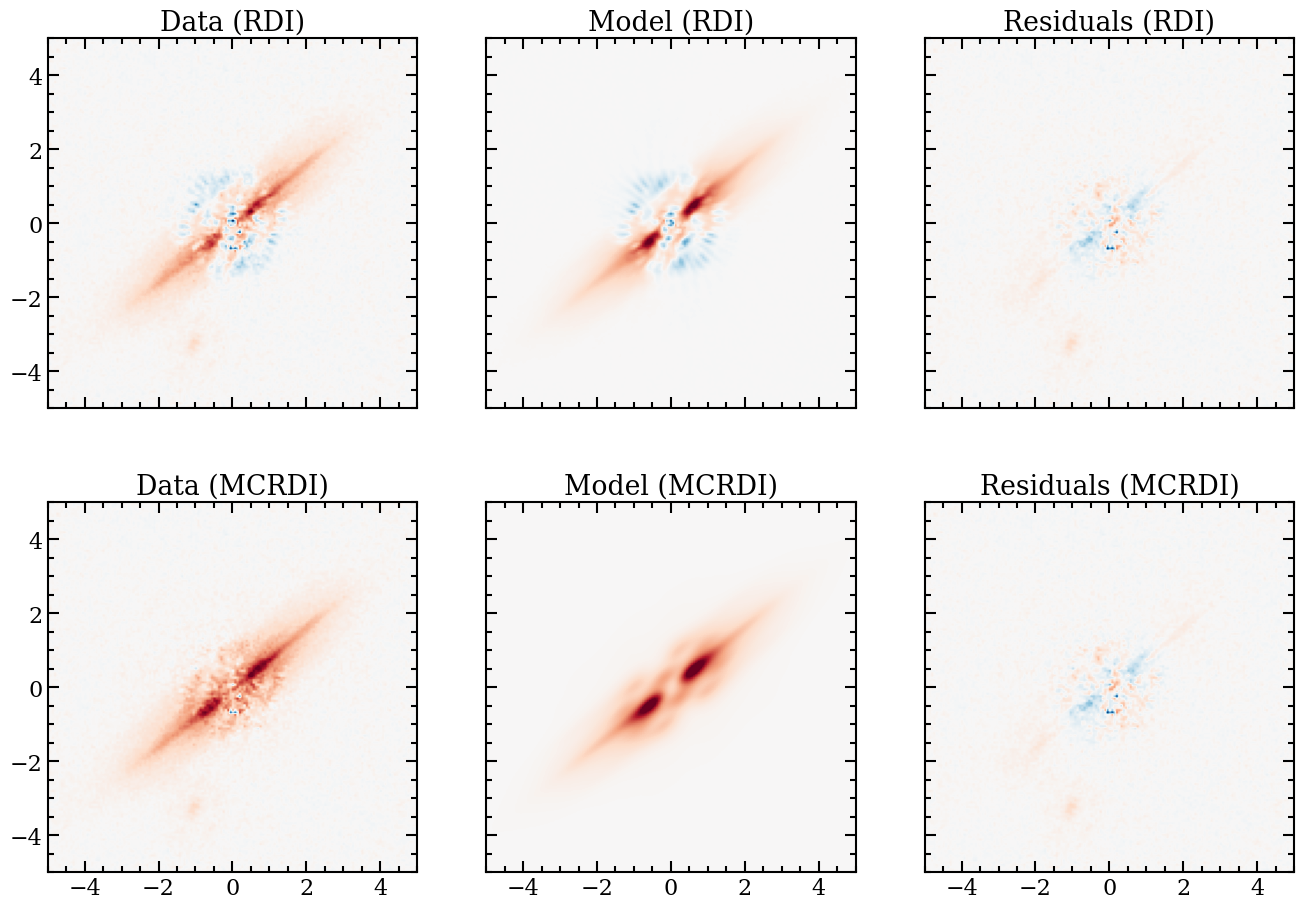

In [12]:
fig,axes = quick_implot([[rdi_reduc.im, fmrdi_reduc.im, rdi_reduc.im-fmrdi_reduc.im],
                         [mcrdi_reduc.im, model_reduc.im, mcrdi_reduc.im-model_reduc.im]],
                        cmap='RdBu_r', clim_perc=99.99, show=False,
                        panelsize=(4.5,5.0), extent=rdi_reduc.extent,
                        lims=[-5,5], show_ticks=True)

labels = ['Data (RDI)', 'Model (RDI)', 'Residuals (RDI)',
          'Data (MCRDI)', 'Model (MCRDI)', 'Residuals (MCRDI)']

for i,ax in enumerate(axes):
    ax.set_title(labels[i])

To think of this in another way: the difference between a standard (unconstrained) RDI reduction and an MCRDI reduction is exactly equal to the effect of forward modeling on the assumed disk model. 

Note: you can also save the currently set circumstellar scene model using the save_circumstellar_model method, which can later be loaded directly with the set_circumstellar_model method.

In [13]:
# Save the current disk model to disk
wdb.save_circumstellar_model(output_ext='cssmodel')

In [14]:
# Load the model from the files
wdb.set_circumstellar_model(model_ext='cssmodel')

In [15]:
# Now, let's a) generalize the GRaTer model to a composite image formed from the super-position of N individual ring-like components, and b) set up an objective function to optimize a disk model for the data.

# (we don't actually need more than 1 ring here — I just had the code already and thought it might be helpful for other applications)

def grater_nring_2hg_disk_model(cent=np.array([160.,160.]),
                                 distance=10., nx=320, ny=320,
                                 pxscale=0.063*u.arcsec/u.pixel, accuracy=None, rmax_accuracy=None,
                                 polar=False, halfNbSlices=25, **disk_params):
    
    composite_image = np.zeros((ny,nx))
    all_rings_finished = False
    i=1
    while not all_rings_finished:
        ring_params = {}
        suffix = f'_{i}'
        for pkey in disk_params:
            if pkey.endswith(suffix):
                ring_params[pkey.replace(suffix, '')] = disk_params[pkey]

        if len(ring_params) == 0:
            all_rings_finished = True
            
        else:
            F_i = ring_params.pop('F', 1)
            composite_image += F_i * grater_2hg_disk_model(**ring_params, cent=cent,
                                                            distance=distance, nx=nx, ny=ny,
                                                            pxscale=pxscale, accuracy=accuracy, 
                                                            rmax_accuracy=rmax_accuracy,
                                                            polar=polar, halfNbSlices=halfNbSlices)
        i+=1
    return composite_image


def model_rescale_factor(A, B, sig=None, mask=None):
    """
    Determines the value of scalar c such that:
        chi^2 = sum [ (A-c*B)^2 / sig^2 ]
    is minimized.
    
    Parameters
    ----------
    A : numpy.ndarray
        Array of measurements
    B : numpy.ndarray
        Array of model values. Shape must match A and B
    sig : numpy.ndarray, optional
        The 1 sigma uncertainty for the measurements of A.
    mask : numpy.ndarray, optional
        A boolean mask with False for entries of A, B, and sig not to be
        utilized, and True for entries that are. Defaults to None.
    Returns
    -------
    c : float
        The scaling factor to multiply the model (B) by to achieve the minimum chi^2
        for measurements (A) having the given uncertainties (sig).
    """
    if np.shape(A) != np.shape(B):
        raise ValueError("A and B must be arrays of the same shape!")
    if sig is not None:
        if np.shape(A) != np.shape(sig):
            raise ValueError("A, B, and sig must be arrays of the same shape if sig is specified!")
    else:
        sig = 1
    if mask is None:
        c = np.nansum(A * B / (sig ** 2)) / np.nansum((B ** 2) / (sig ** 2))
    elif np.shape(mask)[-2:] != np.shape(A)[-2:]:
        raise ValueError("If provided, mask's shape must match the final axes of A, B, and sig!")
    else:
        Amsk, Bmsk = A[..., mask], B[..., mask]
        if np.ndim(sig) != 0:
            Smsk = sig[..., mask]
        else:
            Smsk = sig
        c = np.nansum(Amsk * Bmsk / (Smsk ** 2)) / np.nansum((Bmsk ** 2) / (Smsk ** 2))
    return c


def obj_fn(p, rdi_reduc, wdb, roi, distance, err_weighting=False, rmax_accuracy=None,
           halfNbSlices=25, return_soln=False, q_clip=None, lsq_sfac=True,
           count=True, store_samples=False, clear_each_call=True):
    """
    Parameters
    ----------
    p: lmfit.parameter.Parameters
        LMFit parameters object containing at least: r0_1, h0_1, ain_1, aout_1, pa_1, incl_1, g1_1, g2_1, wg1_1
        
    rdi_reduc: winnie.space.SpaceReduction
        An RDI reduction of the data using the current settings in 'wdb', the Winnie SpaceRDI object;
        the forward-modeled disk image will be compared to rdi_reduc.im
        
    wdb: winnie.space.SpaceRDI
        The Winnie SpaceRDI object that was used to generate rdi_reduc
        
    roi: numpy.ndarray
        Boolean 'region of interest' array having the same shape as rdi_reduc.im that indicates which
        pixels should be included in the goodness of fit evaluation.
        
    distance: float
        Distance to the target star in parsecs.
        
    err_weighting: bool
        If err_weighting is True, the array stored in rdi_reduc.err is used to weight the residuals.
        Unless manually changed, rdi_reduc.err is the propagated pixel uncertainty map based on the ERR
        FITS extension. Currently, these arrays are not accurate (because they neglect the noise reduction 
        from SpaceKLIP's use of psuedo reference pixels). This could be useful if you have significant small
        separation stellar residuals that are affecting your disk model fit.
        
    rmax_accuracy: float
        The largest separation (in au) at which to calculate the disk model. If None, defaults to the edge
        of the FOV.
        
    halfNbSlices: int
        The number of planar slices to compute above and below the disk midplane when generating the raw 
        disk model.
        
    return_soln: bool
        If True, rather than returning a residual array, returns the forward modeled image and some other items
        
    q_clip: tuple or list or numpy.ndarray
        If not None, q_clip gives a lower and upper quantile bound for the residuals. Any values outside the 
        quantile range are clipped when evaluating goodness of fit. Can be useful for data with significant 
        artifacts within the region of interest (e.g., poor reference match, uncorrected hot pixels, etc). 
        E.g., q_clip = [5,95] will compute goodness of fit using only the inner 5th-95%ile of the distribution 
        of residual pixel values in your region of interest.
    
    lsq_sfac: bool
        If True, least-squares renormalize the brightness of the forward modeled disk image to match the data
        within the region of interest (and considering the uncertainties when err_weighting is True). 
        This should nearly always be True.
        
    count: bool
        If True, will advance and display a counter during the optimization. Requires setting 'counter = 0' somewhere
        outside of the function.
        
    store_samples: bool
        If True, each time obj_fn is called with return_soln=False, an array containing the parameters values and the 
        corresponding chi-squared metric will be appended to a list titled samples. Requires setting 'samples = []'
        somewhere outside of the function.
    
    clear_each_calls: bool
        If True, clears the output every time the function is called. Mostly to prevent accumulating a large number 
        of print statements if the loop triggers a warning somewhere.
    """
    pdict = p.valuesdict() 

    if err_weighting:
        sig = rdi_reduc.err
    else:
        sig = None

    # Generate the raw model oriented north-up
    # We generate a detector-sampled raw model, and then subpixelate it before PSF convolution
    # You could alter this to generate an oversampled model quite easily, but in my experience the
    # only difference is runtime.
    raw_model = grater_nring_2hg_disk_model(**pdict, cent=wdb.c_star, distance=distance,
                                            nx=wdb.nx, ny=wdb.ny, pxscale=wdb.pxscale,
                                            rmax_accuracy=rmax_accuracy, halfNbSlices=halfNbSlices)

    # Convolve the model using the prepared SpaceConvolution object then set it as the CSS model in the SpaceRDI object
    wdb.set_circumstellar_model(raw_model=raw_model, raw_model_pxscale=wdb.pxscale, raw_model_center=wdb.c_star)


    # Run RDI on the model to get the forward-modeled result
    fmrdi_reduc = wdb.run_rdi(forward_model=True, save_products=False, collapse_rolls=return_soln)
    
    if lsq_sfac:
        # Rescale the model to minimize residuals with the data
        # Median filter both first to avoid skewing the rescaling with uncorrected hot pixels, etc.
        sfac = model_rescale_factor(*median_filter_sequence(np.array([rdi_reduc.im, fmrdi_reduc.im]),
                                                            footprint=np.array([[0,1,0],
                                                                                [1,1,1],
                                                                                [0,1,0]]),
                                                            prop_threshold=0.8), sig=sig, mask=roi)
    else:
        sfac = 1
        
    fmrdi_reduc.im *= sfac
    
    if return_soln:
        raw_model *= sfac
        wdb.imcube_css *= sfac
        return sfac, raw_model, fmrdi_reduc, wdb

    res = rdi_reduc.im - fmrdi_reduc.im
    
    if sig is not None:
        res /= sig
        
    res = res[roi]
    
    if q_clip is None:
        res = np.abs(res)
    else:
        low,upp = np.nanpercentile(res, q_clip)
        res = np.abs(res[(res >= low) & (res <= upp)])
        
    if clear_each_call:
        clear_output()

    if count:
        global counter
        counter += 1
        print('Models evaluated: {0: <16}'.format(counter), end='\r')
        
    if store_samples: # Append each set of paramaters and the corresponding chisq to a list
        chisq = np.nansum(res**2)
        sample = [pdict[key] for key in pdict.keys()]
        sample.append(chisq)
        samples.append(sample)
        
    return res

For the model optimization procedure below, I'm assuming that the goal is to get a respectable model of the entire disk.

This let's us do things like:
 - perform MCRDI to get a reduction of the data that is ~free of oversubtraction  
 - subtract the disk model to compute better planet detection limits  
 - measure disk brightness from the raw model to avoid PSF convolution effects (which otherwise bias measurements of disk color using multi-band data)  

However, if you are SOLELY interested in getting an optimal model for MCRDI, we technically only need to model the disk within the optimization zone(s) used for PSF subtraction. Any disk flux outside of the optimization zone(s) cannot induce RDI oversubtraction, and so can be neglected. 

In this latter scenario, I would recommend adjusting the region of interest mask (```roi``` below) to simply be the map of pixels included in any of your optimzation zones. 
E.g., 

```roi = np.any(wdb.optzones, axis=0)```

Then, replacing ```wdb.set_crop([201,201])``` with ```wdb.set_crop('auto')``` will automatically crop the FOV to the limits of the optimization zones (plus a few lambda/D padding)

Combined, these should dramatically speed up the model optimization. With that said: even if the interest is purely for MCRDI, I'd recommend against defining a very small optimization zone and modeling only a small segment of the disk. In such cases, you could very easily end up fitting the disk model to stellar PSF residuals or artifacts. Be weary if you attempt this and wind up with an inclination and PA that are dramatically different from expectation: you're probably not fitting the actual disk in your optimization region.


**Cropping**

Cropping the data, as below, can save a significant amount of time in forward modeling. Even if you're working with a disk that spans the entire field of view, if you're using pad_data='auto' you should crop to the original subarray dimensions UNLESS you have bright circumstellar flux falling just outside the nominal FOV. 

JWST_NIRCAM_NRCALONG_F356W_MASKRND_MASK335R_SUB320A335R
Science data:   2 exposures of shape (200,200)
Reference data: 6 exposures of shape (200,200)

RDI Settings:
Extension for output files: 'rdi_psfsub'
1 optimization zone(s)
1 subtraction zone(s)


Parameters([('r0_1', <Parameter 'r0_1', value=35.0, bounds=[25.0:45.0]>), ('h0_1', <Parameter 'h0_1', value=0.038 (fixed), bounds=[0.005:0.06]>), ('ain_1', <Parameter 'ain_1', value=5, bounds=[1:12]>), ('aout_1', <Parameter 'aout_1', value=-5, bounds=[-12:-1]>), ('pa_1', <Parameter 'pa_1', value=128.65 (fixed), bounds=[125.65:131.65]>), ('incl_1', <Parameter 'incl_1', value=89.08 (fixed), bounds=[87.08:89.5]>), ('gamma_1', <Parameter 'gamma_1', value=1.35, bounds=[1.0:3.0]>), ('g1_1', <Parameter 'g1_1', value=0.98, bounds=[-0.99:0.99]>), ('g2_1', <Parameter 'g2_1', value=0.5, bounds=[-0.99:0.99]>), ('wg1_1', <Parameter 'wg1_1', value=0.7, bounds=[0.51:1.0]>), ('F_1', <Parameter 'F_1', value=1 (fixed), bounds=[0.1:10]>)])

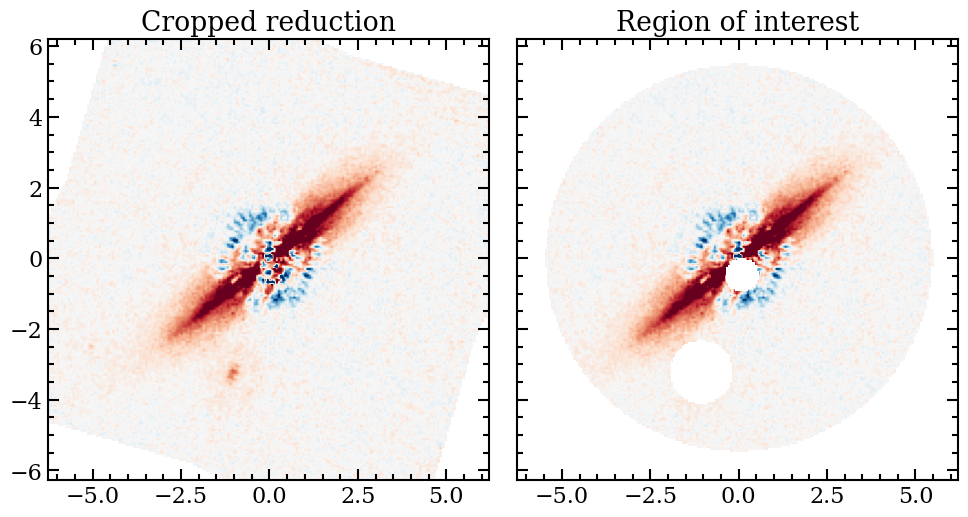

In [17]:
import lmfit

from winnie.utils import (dist_to_pt, ang_size_to_px_size, ang_size_to_proj_sep, px_size_to_ang_size)

# Settings for the radial extent of the region of interest (spanning 0 - 5.5 arcsec in this case)
roi_rmax = 5.5 # arcsec
roi_rmin = 0.0 # arcsec

source_positions = np.array([[-1.06, -3.22], [0.08, -0.48]]) # North-up stellocentric offsets in arcsec (+x is north of star, +y is west of star) of any artifacts or sources you want to exclude from the optimization
source_mask_nfwhms = np.array([6, 3]) # Radii of exclusion regions (in lambda/D) for positions above
# Source 1 above is the background source a few arcsec south of the star. Source 2 is a group of uncorrected "bad" pixels that result in very negative values that may otherwise affect the model 

# Cropped size to use during optimization. Should be large enough to include the entire disk (or at least the part you're interested in) plus some padding for convolution
npx_crop = int(2*(np.ceil(ang_size_to_px_size(roi_rmax, wdb.pxscale).value + 5*wdb._fwhm)))
crop_size = [npx_crop, npx_crop] # Cropped shape

q_clip = None # see obj_fn docstring
err_weighting = False # see obj_fn docstring

#####################
wdb.rdi_presets() # Set back to presets for a standard RDI reduction

wdb.set_crop(crop_size)
y1,y2,x1,x2 = wdb._crop_indices

# Rerun RDI on the cropped data:
rdi_reduc = wdb.run_rdi(save_products=False)

rmap = dist_to_pt(rdi_reduc.c_star, rdi_reduc.nx, rdi_reduc.ny) # Generate a map of the distance of each pixel from the position of the star (in pixels).

# Build our region of interest (ROI) mask; should be True where we want to optimize our disk model and False otherwise
roi_cropped = (rmap >= ang_size_to_px_size(roi_rmin, wdb.pxscale).value) & (rmap <= ang_size_to_px_size(roi_rmax, wdb.pxscale).value)
for i, spos in enumerate(source_positions):
    spos_px = ang_size_to_px_size(spos, wdb.pxscale).value + rdi_reduc.c_star # Convert to pixel position
    roi_cropped[dist_to_pt(spos_px, rdi_reduc.nx, rdi_reduc.ny) <= (source_mask_nfwhms[i]*wdb._fwhm)] = False

# The largest separation (in au) at which to calculate the disk model. Here, we truncate the calculation at ~ the edge of the cropped FOV
rmax_accuracy = ang_size_to_proj_sep(px_size_to_ang_size(npx_crop/2., wdb.pxscale), distance).value # Convert to au

fig,(ax1,ax2) = quick_implot([rdi_reduc.im, np.where(roi_cropped, rdi_reduc.im, np.nan)], cmap='RdBu_r', clim_perc=99, show=False, show_ticks=True, extent=rdi_reduc.extent)
ax1.set_title('Cropped reduction')
ax2.set_title('Region of interest')

p = lmfit.Parameters()

i = 1 # Ring 1 (the only ring for this example)
# Initial parameter guesses:
r0, h0, ain, aout, pa, incl, gamma = 35., 0.038, 5, -5, 128.65, 89.08, 1.35 # Dust distribution parameters
g1, g2, wg1 = 0.98, 0.5, 0.7 # SPF parameters

p.add(f'r0_{i}',    value=r0,     min=r0-10,                max=r0+10,             vary=True)
p.add(f'h0_{i}',    value=h0,     min=0.005,                max=0.06,              vary=False)
p.add(f'ain_{i}',   value=ain,    min=1,                    max=12,                vary=True)
p.add(f'aout_{i}',  value=aout,   min=-12,                  max=-1,                vary=True)
p.add(f'pa_{i}',    value=pa,     min=pa-3,                 max=pa+3,              vary=False)
p.add(f'incl_{i}',  value=incl,   min=max(incl-2, -89.5),   max=min(incl+2, 89.5), vary=False)
p.add(f'gamma_{i}', value=gamma,  min=1.0,                  max=3.0,               vary=True)
p.add(f'g1_{i}',    value=g1,     min=-0.99,                max=0.99,              vary=True)
p.add(f'g2_{i}',    value=g2,     min=-0.99,                max=0.99,              vary=True)
p.add(f'wg1_{i}',   value=wg1,    min=0.51,                 max=1.0,               vary=True)
p.add(f'F_{i}',     value=1,      min=0.1,                  max=10,                vary=False) 
# F_{i} is the overall scaling factor for this ring; you should set vary=True for any ring components after the first in a multi-ring geometry
# We're using vary=False for ring 1 because we analytically rescale the entire model after forward modeling to minimize residuals much more quickly than optimizing an additional parameter

p

The plot on the right above shows your initial RDI reduction with everything outside the ROI set to NaN (white). To a reasonable approximation, everything that isn't masked should either be the flux you're modeling (disk flux in this case), oversubtraction artifacts, or noise.

Note: the way obj_fn is set up, you can pass in a paramater object ('p' above) containing some additional variables if desired. These include:

'beta', which controls the disk's radial flaring

'e' and 'omega', which control the disk eccentricity and argument of periastron (degrees)

E.g., to add eccentricity to your disk model, you could add the following lines when setting up your lmfit.Parameters object:

```
p.add(f'e_{i}',     value=0.,      min=0.,       max=0.5,   vary=True)
p.add(f'omega_{i}', value=0.,      min=-180,     max=180,   vary=True)
```

Additionally, you can include any arbitrary number of ring components. "i=1" denotes the first ring. A second could be added by copying and pasting the 'p.add' block above, setting i=2, and adjusting the initial values accordingly.

```
i = 2 # Ring 2
# Initial parameter guesses:
r0, h0, ain, aout, pa, incl, gamma = ... # ring 2 values here
g1, g2, wg1 = ... # ring 2 values here

p.add(f'r0_{i}',    value=r0,     min=r0-10,                max=r0+10,             vary=True)
p.add(f'h0_{i}',    value=h0,     min=0.005,                max=0.06,              vary=False)
p.add(f'ain_{i}',   value=ain,    min=1,                    max=12,                vary=True)
p.add(f'aout_{i}',  value=aout,   min=-12,                  max=-1,                vary=True)
p.add(f'pa_{i}',    value=pa,     min=pa-3,                 max=pa+3,              vary=False)
p.add(f'incl_{i}',  value=incl,   min=max(incl-2, -89.5),   max=min(incl+2, 89.5), vary=False)
p.add(f'gamma_{i}', value=gamma,  min=1.0,                  max=3.0,               vary=True)
p.add(f'g1_{i}',    value=g1,     min=-0.99,                max=0.99,              vary=True)
p.add(f'g2_{i}',    value=g2,     min=-0.99,                max=0.99,              vary=True)
p.add(f'wg1_{i}',   value=wg1,    min=0.51,                 max=1.0,               vary=True)
p.add(f'F_{i}',     value=1,      min=0.1,                  max=10,                vary=True) 
```

When adding a second (or more) rings, you'll want to set F_{i} to vary=True for i=2 or above. For one ring, we don't need to vary F as we tune the overall disk brightness analytically after forward modeling anyway. For multiple rings, the value will govern the contrast between the rings and so must be varied.  

A neat feature in LMFit is that you can set a parameter to be a function of one or more other parameters. So, if you want a two ring geometry where the inclination and PA of the 2nd ring are the same as those of the first, you could just do:

```
p.add('pa_2', expr='pa_1')
p.add('incl_2', expr='incl_1')
```

**Note: GRaTer is a very simple scattered-light disk modeling code. I'm using it here because it's very fast. Exercise caution in interpreting the fit parameters.**

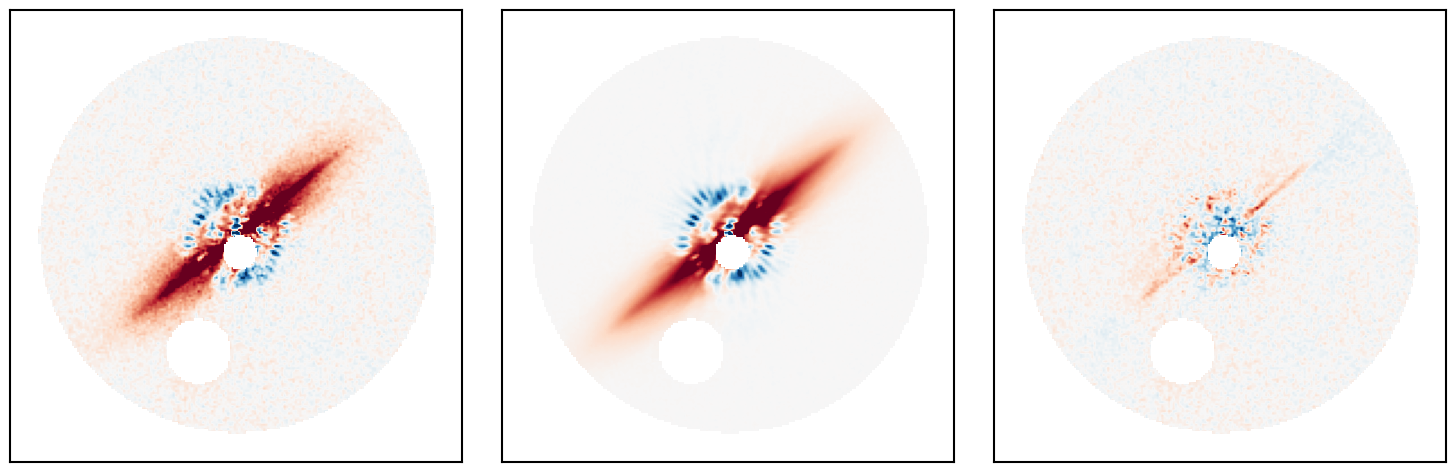

In [18]:
# Run a test model using the initialization and plot the result
sfac, model_raw, fmrdi_reduc, wdb = obj_fn(p, rdi_reduc, wdb, roi_cropped, distance, err_weighting=err_weighting,
                                           rmax_accuracy=rmax_accuracy, count=False, halfNbSlices=25,
                                           return_soln=True, q_clip=q_clip)

pim = np.array([rdi_reduc.im, fmrdi_reduc.im, rdi_reduc.im-fmrdi_reduc.im])

quick_implot(np.where(roi_cropped, pim, np.nan), clim_perc=99., cmap='RdBu_r')

In [19]:
# Carry out the optimization procedure
# This requires ~600 samples when I run it, and takes ~5 minutes on my laptop
counter = 0
res = lmfit.minimize(obj_fn, p, method='powell',
                     args=[rdi_reduc, wdb, roi_cropped, distance], nan_policy='omit',
                     kws=dict(err_weighting=err_weighting, rmax_accuracy=rmax_accuracy,
                              count=True, halfNbSlices=12, q_clip=q_clip, clear_each_call=False))

res

In [20]:
# Uncrop the data, rerun RDI, then rerun the best fitting model solution for the full frame
wdb.set_crop()
wdb.rdi_presets()
rdi_reduc = wdb.run_rdi(save_products=True)

roi = np.zeros((rdi_reduc.ny, rdi_reduc.nx), dtype=bool)
roi[y1:y2, x1:x2] = roi_cropped

sfac, model_raw, fmrdi_reduc, wdb = obj_fn(res.params, rdi_reduc, wdb, roi, distance, err_weighting=err_weighting,
                                           rmax_accuracy=None, count=False, halfNbSlices=50, return_soln=True, q_clip=q_clip)

JWST_NIRCAM_NRCALONG_F356W_MASKRND_MASK335R_SUB320A335R
Science data:   2 exposures of shape (429,430)
Reference data: 6 exposures of shape (429,430)

RDI Settings:
Extension for output files: 'rdi_psfsub'
1 optimization zone(s)
1 subtraction zone(s)


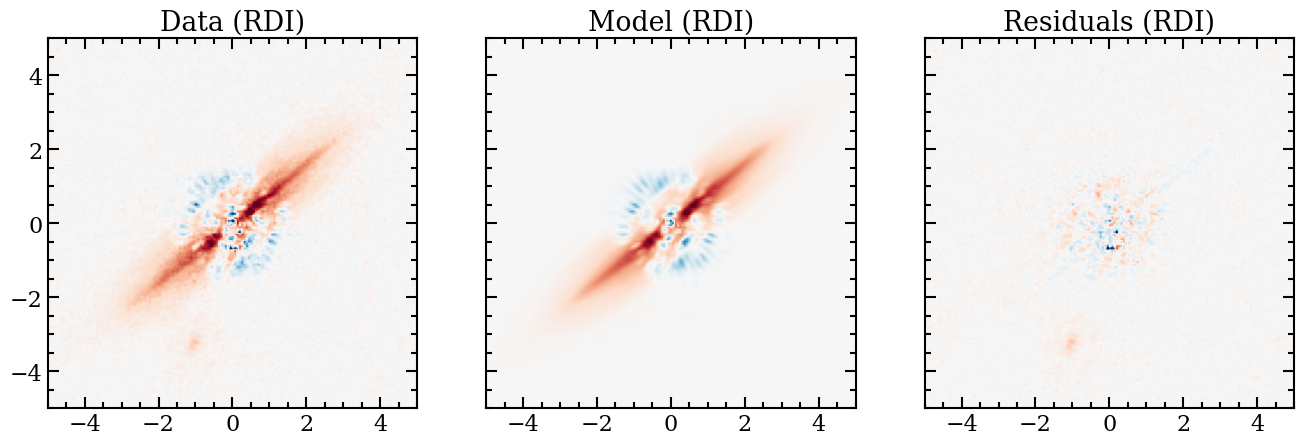

In [21]:
fig,axes = quick_implot([rdi_reduc.im, fmrdi_reduc.im, rdi_reduc.im-fmrdi_reduc.im],
                        cmap='RdBu_r', clim_perc=99.99, show=False,
                        panelsize=(4.5,5.0), extent=rdi_reduc.extent,
                        lims=[-5,5], show_ticks=True)

labels = ['Data (RDI)', 'Model (RDI)', 'Residuals (RDI)']

for i,ax in enumerate(axes):
    ax.set_title(labels[i])

Use our best-fit model to carry out MCRDI

Note: our final call to obj_fn already set the best-fit model as the disk model in our SpaceRDI object. So we just need to change our presets to MCRDI and execute run_rdi again

In [22]:
wdb.mcrdi_presets()
mcrdi_reduc = wdb.run_rdi()
model_reduc = wdb.derotate_and_combine_circumstellar_model()

JWST_NIRCAM_NRCALONG_F356W_MASKRND_MASK335R_SUB320A335R
Science data:   2 exposures of shape (429,430)
Reference data: 6 exposures of shape (429,430)

RDI Settings:
'hcube_css': <class 'numpy.ndarray'> of shape (2, 1, 429, 430)
Extension for output files: 'mcrdi_psfsub'
1 optimization zone(s)
1 subtraction zone(s)


In [23]:
# Generate HPFRDI results for comparison:
wdb.hpfrdi_presets()
hpfrdi_reduc = wdb.run_rdi(save_products=True)
fmhpfrdi_reduc = wdb.run_rdi(forward_model=True)

JWST_NIRCAM_NRCALONG_F356W_MASKRND_MASK335R_SUB320A335R
Science data:   2 exposures of shape (429,430)
Reference data: 6 exposures of shape (429,430)

RDI Settings:
'opt_smoothing_fn': <function high_pass_filter_sequence at 0x1476a5440>
'opt_smoothing_kwargs': {'filtersize': 0.969667093183099}
Extension for output files: 'hpfrdi_psfsub'
1 optimization zone(s)
1 subtraction zone(s)


In [24]:
# Make a SpaceReduction object for the raw model as well
raw_reduc = winnie.SpaceReduction(spacerdi=wdb, im=model_raw, c_star_out=wdb.c_star, output_ext='rawmodel')

# Make a dictionary with some extra info about the best-fit model and optimization settings
model_dict = res.params.valuesdict()
model_dict.update(dict(sfac=sfac, q_clip=str(q_clip), err_weighting=err_weighting))

# For all model-dependent results, add extra model info to the header and then save
for reduc in [fmrdi_reduc, mcrdi_reduc, model_reduc, fmhpfrdi_reduc, raw_reduc]:
    reduc.primary_header.update(model_dict)
    reduc.save(overwrite=True)
    
# Save the circumstellar model to disk so it can be loaded back with set_circumstellar_model later if needed.
wdb.save_circumstellar_model(model_dict=model_dict)
    
model_params0 = res.params.copy() # Save these for initializing the next filter

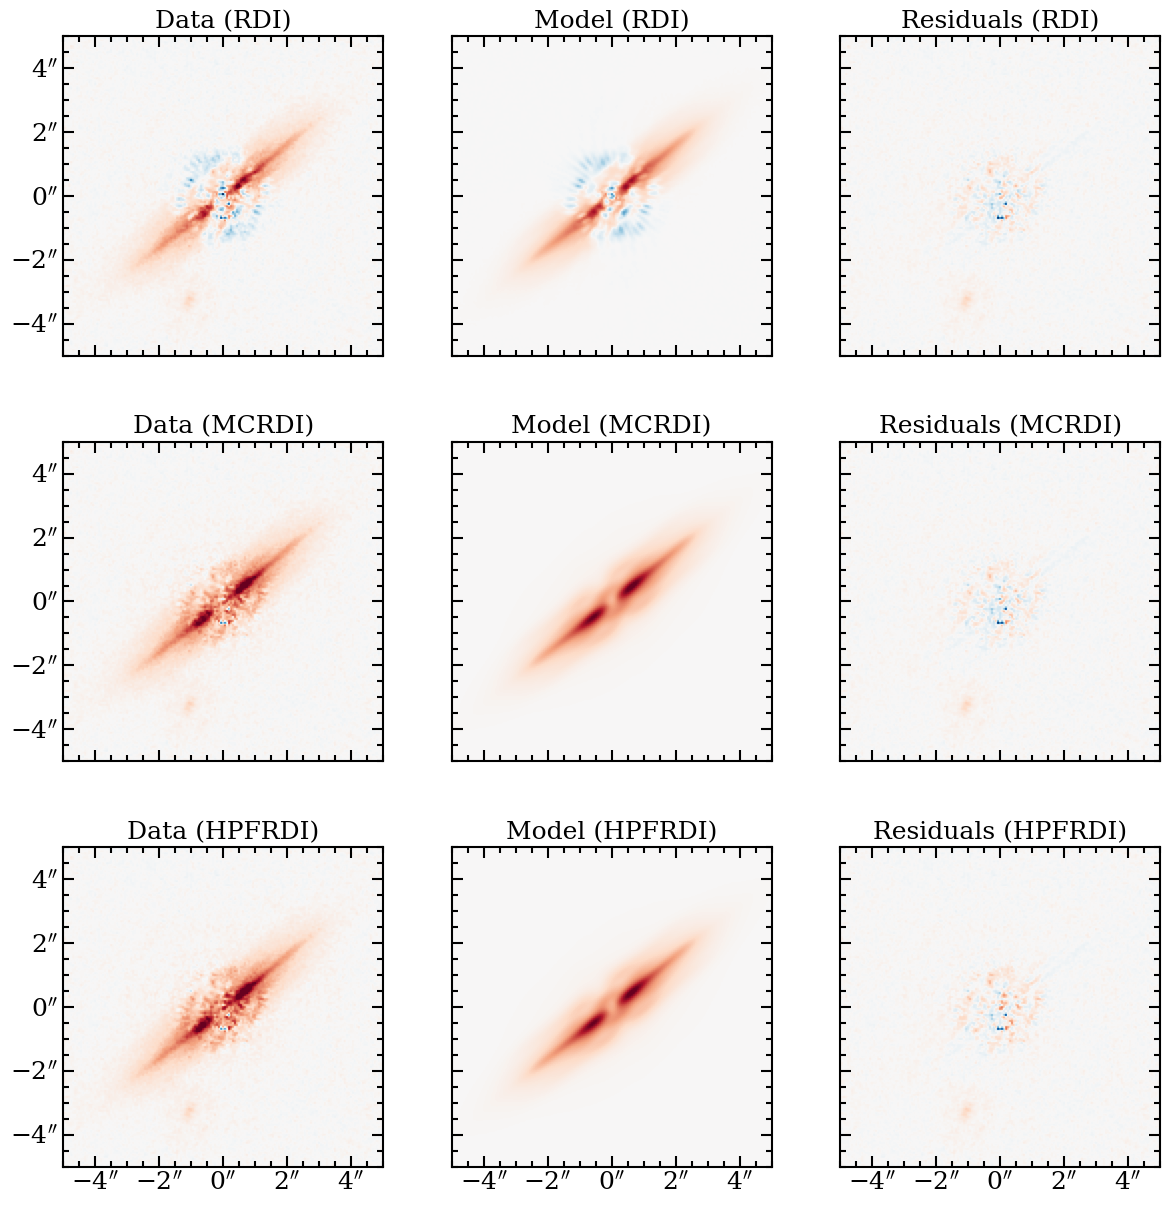

In [25]:
plot_args = dict(cmap='RdBu_r', clim_perc=99.99, show=False, panelsize=(4.,4.25),
                 extent=rdi_reduc.extent, lims=[-5,5], show_ticks=True)

# Plot all three reductions
fig,axes = quick_implot([[rdi_reduc.im, fmrdi_reduc.im, rdi_reduc.im-fmrdi_reduc.im],
                         [mcrdi_reduc.im, model_reduc.im, mcrdi_reduc.im-model_reduc.im],
                         [hpfrdi_reduc.im, fmhpfrdi_reduc.im, hpfrdi_reduc.im-fmhpfrdi_reduc.im]], **plot_args)

labels = ['Data (RDI)', 'Model (RDI)', 'Residuals (RDI)',
          'Data (MCRDI)', 'Model (MCRDI)', 'Residuals (MCRDI)',
          'Data (HPFRDI)', 'Model (HPFRDI)', 'Residuals (HPFRDI)']

for i,ax in enumerate(axes):
    ax.set_title(labels[i], fontsize=18)
    ax.tick_params(labelsize=18)
    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_major_locator(mpl.ticker.MaxNLocator(5, integer=True, min_n_ticks=5))
        axis.set_major_formatter("${x:0.0f}''$")

plt.savefig(raw_reduc.filename.replace('_rawmodel.fits', '_reducs.pdf'), bbox_inches='tight')

plt.show()

# Carry out the same procedure for the F444W (but more compactly)

In [26]:
wdb.load_concat(1) # load the F444W data

JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R
Science data:   2 exposures of shape (429,430)
Reference data: 6 exposures of shape (429,430)

RDI Settings:
Extension for output files: 'rdi_psfsub'
1 optimization zone(s)
1 subtraction zone(s)


  0%|          | 0/41 [00:00<?, ?it/s]

JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R
Science data:   2 exposures of shape (429,430)
Reference data: 6 exposures of shape (429,430)

RDI Settings:
Extension for output files: 'rdi_psfsub'
1 optimization zone(s)
1 subtraction zone(s)


Parameters([('r0_1', <Parameter 'r0_1', value=29.715087904078228 (fixed), bounds=[25.0:45.0]>), ('h0_1', <Parameter 'h0_1', value=0.038 (fixed), bounds=[0.005:0.06]>), ('ain_1', <Parameter 'ain_1', value=6.050886545205444 (fixed), bounds=[1:12]>), ('aout_1', <Parameter 'aout_1', value=-5.039191638580082 (fixed), bounds=[-12:-1]>), ('pa_1', <Parameter 'pa_1', value=128.65 (fixed), bounds=[125.65:131.65]>), ('incl_1', <Parameter 'incl_1', value=89.08 (fixed), bounds=[87.08:89.5]>), ('gamma_1', <Parameter 'gamma_1', value=1.725466032577036 (fixed), bounds=[1.0:3.0]>), ('g1_1', <Parameter 'g1_1', value=0.9858829254825896, bounds=[-0.99:0.99]>), ('g2_1', <Parameter 'g2_1', value=0.5126718558413068, bounds=[-0.99:0.99]>), ('wg1_1', <Parameter 'wg1_1', value=0.6963243128814597, bounds=[0.51:1.0]>), ('F_1', <Parameter 'F_1', value=1 (fixed), bounds=[0.1:10]>)])

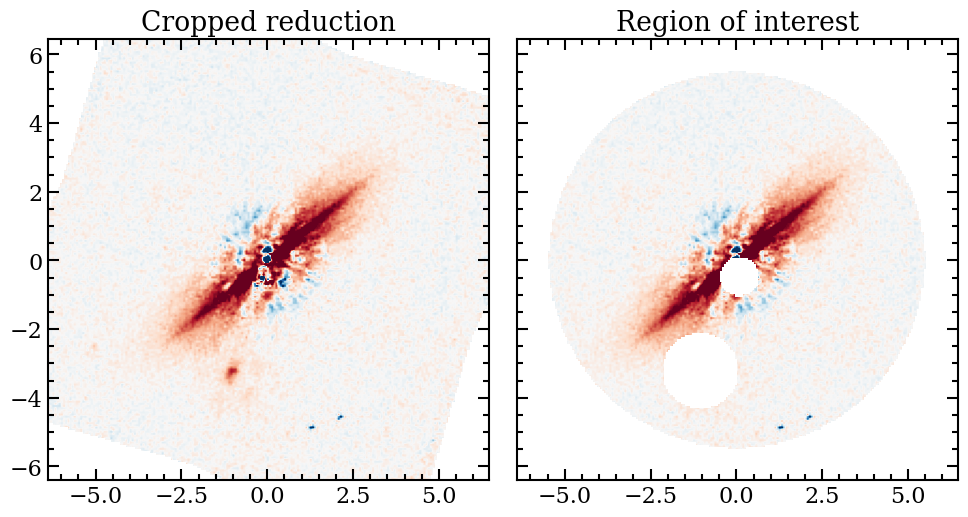

In [27]:
# Setup up for forward model optimization
# Only recalculating the settings that might change between concats (e.g., for different pxscale and PSF FWHM)
npx_crop = int(2*(np.ceil(winnie.utils.ang_size_to_px_size(roi_rmax, wdb.pxscale).value + 5*wdb._fwhm)))
crop_size = [npx_crop,npx_crop] # Cropped shape

#####################
wdb.rdi_presets() # Set to presets for a standard RDI reduction to be safe
wdb.set_crop(crop_size)

y1,y2,x1,x2 = wdb._crop_indices
rdi_reduc = wdb.run_rdi(save_products=False)

rmap = winnie.utils.dist_to_pt(rdi_reduc.c_star, rdi_reduc.nx, rdi_reduc.ny) # Generate a map of the distance of each pixel from the position of the star (in pixels).

# Build our region of interest (ROI) mask; should be True where we want to optimize our disk model and False otherwise
roi_cropped = (rmap >= winnie.utils.ang_size_to_px_size(roi_rmin, wdb.pxscale).value) & (rmap <= winnie.utils.ang_size_to_px_size(roi_rmax, wdb.pxscale).value)
for i, spos in enumerate(source_positions):
    spos_px = winnie.utils.ang_size_to_px_size(spos, wdb.pxscale).value + rdi_reduc.c_star
    roi_cropped[winnie.utils.dist_to_pt(spos_px, rdi_reduc.nx, rdi_reduc.ny) <= (source_mask_nfwhms[i]*wdb._fwhm)] = False

# The largest separation (in au) at which to calculate the disk model. Here, we truncate the calculation at ~ the edge of the cropped FOV
rmax_accuracy = ang_size_to_proj_sep(px_size_to_ang_size(npx_crop/2., wdb.pxscale), distance).value # Convert to au

fig,(ax1,ax2) = quick_implot([rdi_reduc.im, np.where(roi_cropped, rdi_reduc.im, np.nan)], cmap='RdBu_r', clim_perc=99, show=False, show_ticks=True, extent=rdi_reduc.extent)
ax1.set_title('Cropped reduction')
ax2.set_title('Region of interest')

p = model_params0.copy()
for param in p:
    if not param.startswith('g1_') and not param.startswith('g2_') and not param.startswith('wg1_'):
        p[param].vary = False
        
p

Note: the two negative spots in the ~ lower right are clearly artifacts, but are far enough away from the disk that they're unlikely to affect the result. You can always add these points to your "source positions" list, if you're concerned about them.

In [28]:
# Carry out the optimization procedure; should be faster varying only 3 parameters here.
# This requires ~350 samples when I run it, and takes ~3 minutes on my laptop
counter = 0
res = lmfit.minimize(obj_fn, p, method='powell',
                     args=[rdi_reduc, wdb, roi_cropped, distance], nan_policy='omit',
                     kws=dict(err_weighting=err_weighting, rmax_accuracy=rmax_accuracy,
                              count=True, halfNbSlices=12, q_clip=q_clip, clear_each_call=False))
res

JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R
Science data:   2 exposures of shape (429,430)
Reference data: 6 exposures of shape (429,430)

RDI Settings:
Extension for output files: 'rdi_psfsub'
1 optimization zone(s)
1 subtraction zone(s)
JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R
Science data:   2 exposures of shape (429,430)
Reference data: 6 exposures of shape (429,430)

RDI Settings:
'hcube_css': <class 'numpy.ndarray'> of shape (2, 1, 429, 430)
Extension for output files: 'mcrdi_psfsub'
1 optimization zone(s)
1 subtraction zone(s)
JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R
Science data:   2 exposures of shape (429,430)
Reference data: 6 exposures of shape (429,430)

RDI Settings:
'opt_smoothing_fn': <function high_pass_filter_sequence at 0x1476a5440>
'opt_smoothing_kwargs': {'filtersize': 1.197928007385561}
Extension for output files: 'hpfrdi_psfsub'
1 optimization zone(s)
1 subtraction zone(s)


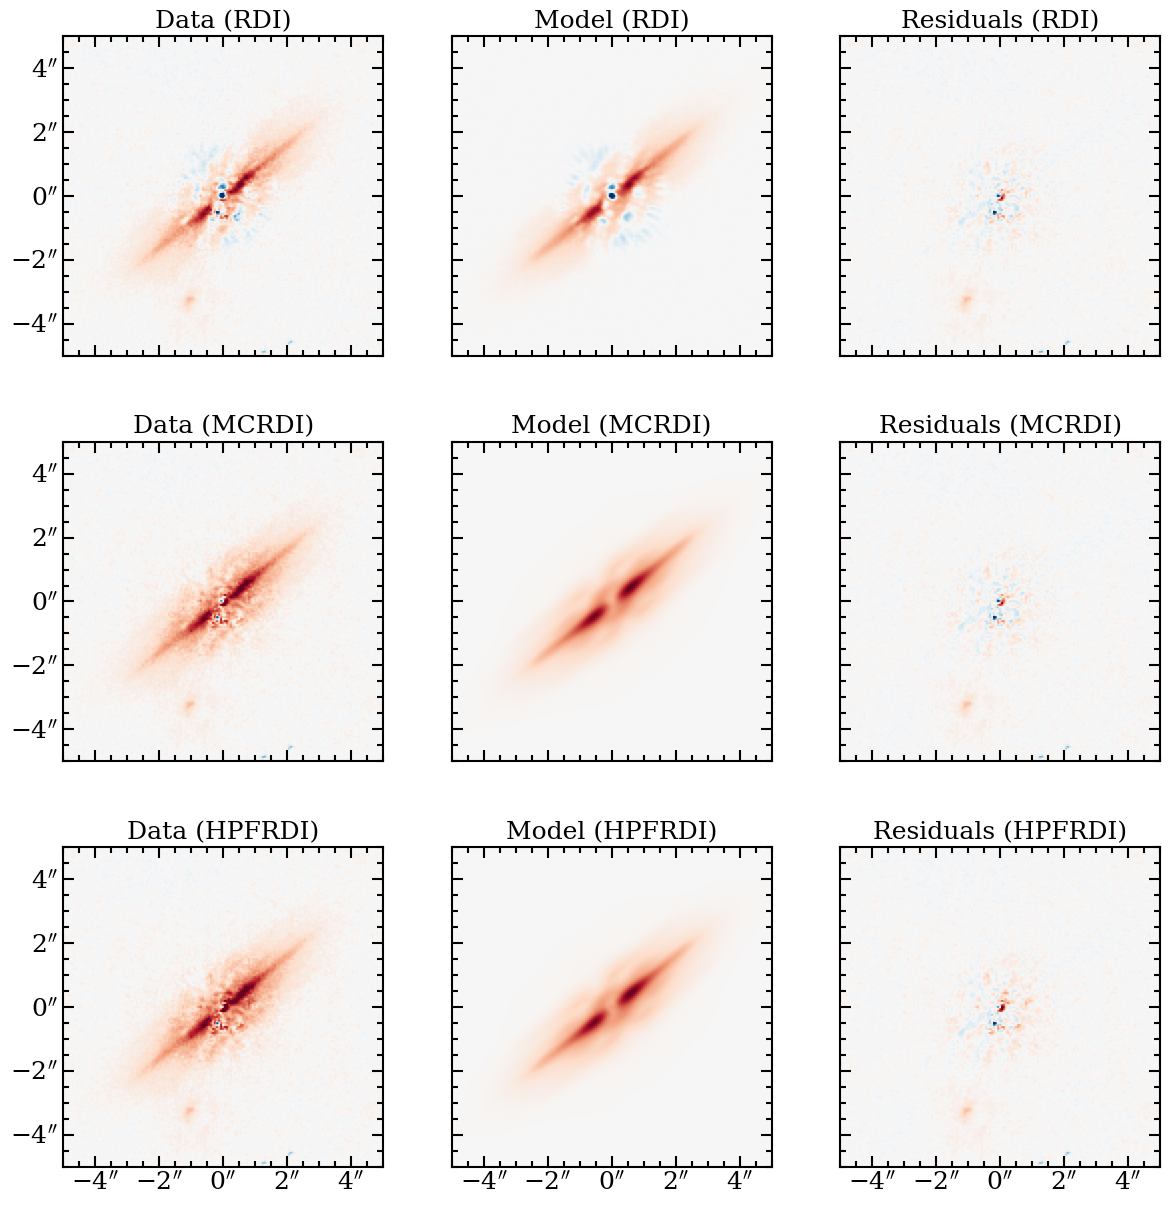

In [29]:
# Uncrop the data, rerun RDI, then reproduce the best fitting model solution
y1,y2,x1,x2 = wdb._crop_indices

wdb.set_crop()
wdb.rdi_presets()
rdi_reduc = wdb.run_rdi(save_products=True)

roi = np.zeros((rdi_reduc.ny, rdi_reduc.nx), dtype=bool)
roi[y1:y2, x1:x2] = roi_cropped

sfac, model_raw, fmrdi_reduc, wdb = obj_fn(res.params, rdi_reduc, wdb, roi, distance, err_weighting=err_weighting,
                                           rmax_accuracy=None,
                                           count=False, halfNbSlices=50,
                                           return_soln=True, q_clip=q_clip)

# Run MCRDI
wdb.mcrdi_presets()
mcrdi_reduc = wdb.run_rdi()
model_reduc = wdb.derotate_and_combine_circumstellar_model()

# Run HPFRDI:
wdb.hpfrdi_presets()
hpfrdi_reduc = wdb.run_rdi(save_products=True)
fmhpfrdi_reduc = wdb.run_rdi(forward_model=True)

# Make a SpaceReduction object for the raw model as well
raw_reduc = winnie.SpaceReduction(spacerdi=wdb, im=model_raw, c_star_out=wdb.c_star, output_ext='rawmodel')

# Make a dictionary with some extra info about the best-fit model and optimization settings
model_dict = res.params.valuesdict()
model_dict.update(dict(sfac=sfac, q_clip=str(q_clip), err_weighting=err_weighting))
# For all model-dependent results, add extra model info to the header and then save
for reduc in [fmrdi_reduc, mcrdi_reduc, model_reduc, fmhpfrdi_reduc, raw_reduc]:
    reduc.primary_header.update(model_dict)
    reduc.save(overwrite=True)
    
# Save the circumstellar model to disk so it can be loaded back with set_circumstellar_model later if needed.
wdb.save_circumstellar_model(model_dict=model_dict)
    
plot_args = dict(cmap='RdBu_r', clim_perc=99.99, show=False, panelsize=(4.,4.25),
                 extent=rdi_reduc.extent, lims=[-5,5], show_ticks=True)

# Plot all three reductions
fig,axes = quick_implot([[rdi_reduc.im, fmrdi_reduc.im, rdi_reduc.im-fmrdi_reduc.im],
                         [mcrdi_reduc.im, model_reduc.im, mcrdi_reduc.im-model_reduc.im],
                         [hpfrdi_reduc.im, fmhpfrdi_reduc.im, hpfrdi_reduc.im-fmhpfrdi_reduc.im]], **plot_args)

labels = ['Data (RDI)', 'Model (RDI)', 'Residuals (RDI)',
          'Data (MCRDI)', 'Model (MCRDI)', 'Residuals (MCRDI)',
          'Data (HPFRDI)', 'Model (HPFRDI)', 'Residuals (HPFRDI)']

for i,ax in enumerate(axes):
    ax.set_title(labels[i], fontsize=18)
    ax.tick_params(labelsize=18)
    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_major_locator(mpl.ticker.MaxNLocator(5, integer=True, min_n_ticks=5))
        axis.set_major_formatter("${x:0.0f}''$")

plt.savefig(raw_reduc.filename.replace('_rawmodel.fits', '_reducs.pdf'), bbox_inches='tight')

plt.show()

### Of course, you could simply run this procedure in a for-loop over the concatenations (especially for data with more filters!):

**This might look something like the following.**

```
import lmfit

plot_args = dict(cmap='RdBu_r', clim_perc=99.99, show=False, panelsize=(4.,4.25),
                 extent=rdi_reduc.extent, lims=[-5,5], show_ticks=True)

# Settings for the radial extent of the region of interest (spanning 0.0 - 5.5 arcsec in this case)
roi_rmax = 5.5 # arcsec
roi_rmin = 0.0 # arcsec

source_positions = np.array([[-1.06, -3.22], [0.08, -0.48]]) # North-up stellocentric offsets in arcsec (+x is north of star, +y is west of star) of any artifacts or sources you want to exclude from the optimization
source_mask_nfwhms = np.array([6, 3]) # Radii of exclusion regions for positions above in lambda/D

q_clip = None 
err_weighting = False 

# Initial parameter guesses:
r0, h0, ain, aout, pa, incl, gamma = 35., 0.038, 5, -5, 128.65, 89.08, 1.35 # Dust distribution parameters
g1, g2, wg1 = 0.98, 0.5, 0.7 # SPF parameters

p = lmfit.Parameters()
p.add(f'r0_1',    value=r0,     min=r0-10,                max=r0+10,             vary=True)
p.add(f'h0_1',    value=h0,     min=0.005,                max=0.06,              vary=False)
p.add(f'ain_1',   value=ain,    min=1,                    max=12,                vary=True)
p.add(f'aout_1',  value=aout,   min=-12,                  max=-1,                vary=True)
p.add(f'pa_1',    value=pa,     min=pa-3,                 max=pa+3,              vary=False)
p.add(f'incl_1',  value=incl,   min=max(incl-2, -89.5),   max=min(incl+2, 89.5), vary=False)
p.add(f'gamma_1', value=gamma,  min=1.0,                  max=3.0,               vary=True)
p.add(f'g1_1',    value=g1,     min=-0.99,                max=0.99,              vary=True)
p.add(f'g2_1',    value=g2,     min=-0.99,                max=0.99,              vary=True)
p.add(f'wg1_1',   value=wg1,    min=0.51,                 max=1.0,               vary=True)
p.add(f'F_1',     value=1,      min=0.1,                  max=10,                vary=False)

for j,concat in enumerate(wdb.database.obs):
    wdb.load_concat(concat)
    
    # Cropped size to use during optimization. Should be large enough to include the entire disk (or at least the part you're interested in) plus some padding for convolution
    npx_crop = int(2*(np.ceil(winnie.utils.ang_size_to_px_size(roi_rmax, wdb.pxscale).value + 5*wdb._fwhm)))
    crop_size = [npx_crop, npx_crop] # Cropped shape

    wdb.set_crop(crop_size)
    y1,y2,x1,x2 = wdb._crop_indices

    # Rerun RDI on the cropped data:
    rdi_reduc = wdb.run_rdi(save_products=False)

    rmap = dist_to_pt(rdi_reduc.c_star, rdi_reduc.nx, rdi_reduc.ny) # Generate a map of the distance of each pixel from the position of the star (in pixels).

    # Build our region of interest (ROI) mask; should be True where we want to optimize our disk model and False otherwise
    roi_cropped = (rmap >= ang_size_to_px_size(roi_rmin, wdb.pxscale).value) & (rmap <= ang_size_to_px_size(roi_rmax, wdb.pxscale).value)
    for i, spos in enumerate(source_positions):
        spos_px = ang_size_to_px_size(spos, wdb.pxscale).value + rdi_reduc.c_star # Convert to pixel position
        roi_cropped[dist_to_pt(spos_px, rdi_reduc.nx, rdi_reduc.ny) <= (source_mask_nfwhms[i]*wdb._fwhm)] = False

    # The largest separation (in au) at which to calculate the disk model. Here, we truncate the calculation at ~ the edge of the cropped FOV
    rmax_accuracy = ang_size_to_proj_sep(px_size_to_ang_size(npx_crop/2., wdb.pxscale), distance).value # Convert to au
    
    if j > 0: # For each concat after the first, initialize with the previous iteration's best-fit and lock all geometry parameters
        p = res.params.copy()
        for param in p:
            if not param.startswith('g1_') and not param.startswith('g2_') and not param.startswith('wg1_'):
                p[param].vary = False
    
    # Carry out the optimization procedure
    counter = 0
    res = lmfit.minimize(obj_fn, p, method='powell',
                         args=[rdi_reduc, wdb, roi_cropped, distance], nan_policy='omit',
                         kws=dict(err_weighting=err_weighting, rmax_accuracy=rmax_accuracy,
                                  count=True, halfNbSlices=12, q_clip=q_clip, clear_each_call=False))

    # Uncrop the data, rerun RDI, then reproduce the best fitting model solution
    y1,y2,x1,x2 = wdb._crop_indices

    wdb.set_crop()
    wdb.rdi_presets()
    rdi_reduc = wdb.run_rdi(save_products=True)

    roi = np.zeros((rdi_reduc.ny, rdi_reduc.nx), dtype=bool)
    roi[y1:y2, x1:x2] = roi_cropped
    
    sfac, model_raw, fmrdi_reduc, wdb = obj_fn(res.params, rdi_reduc, wdb, roi, distance, err_weighting=err_weighting,
                                               rmax_accuracy=None, count=False, halfNbSlices=50, return_soln=True, q_clip=q_clip)

    # MCRDI
    wdb.mcrdi_presets()
    mcrdi_reduc = wdb.run_rdi()
    model_reduc = wdb.derotate_and_combine_circumstellar_model()

    # HPFRDI
    wdb.hpfrdi_presets()
    hpfrdi_reduc = wdb.run_rdi(save_products=True)
    fmhpfrdi_reduc = wdb.run_rdi(forward_model=True)

    # Make a SpaceReduction object for the raw model as well, so we can write it to disk
    raw_reduc = winnie.SpaceReduction(spacerdi=wdb, im=model_raw, c_star_out=wdb.c_star, output_ext='rawmodel')

    # Make a dictionary with some extra info about the best-fit model and optimization settings
    model_dict = res.params.valuesdict()
    model_dict.update(dict(sfac=sfac, q_clip=str(q_clip), err_weighting=err_weighting))
    # For all model-dependent results, add extra model info to the header and then save
    for reduc in [fmrdi_reduc, mcrdi_reduc, model_reduc, fmhpfrdi_reduc, raw_reduc]:
        reduc.primary_header.update(model_dict)
        reduc.save(overwrite=True)
        
    # Save the circumstellar model to disk so it can be loaded back with set_circumstellar_model later if needed.
    wdb.save_circumstellar_model(model_dict=model_dict)
    
    # Plot all three reductions
    fig,axes = quick_implot([[rdi_reduc.im, fmrdi_reduc.im, rdi_reduc.im-fmrdi_reduc.im],
                             [mcrdi_reduc.im, model_reduc.im, mcrdi_reduc.im-model_reduc.im],
                             [hpfrdi_reduc.im, fmhpfrdi_reduc.im, hpfrdi_reduc.im-fmhpfrdi_reduc.im]], **plot_args)

    labels = ['Data (RDI)', 'Model (RDI)', 'Residuals (RDI)',
              'Data (MCRDI)', 'Model (MCRDI)', 'Residuals (MCRDI)',
              'Data (HPFRDI)', 'Model (HPFRDI)', 'Residuals (HPFRDI)']

    for i,ax in enumerate(axes):
        ax.set_title(labels[i], fontsize=18)
        ax.tick_params(labelsize=18)
        for axis in [ax.xaxis, ax.yaxis]:
            axis.set_major_locator(mpl.ticker.MaxNLocator(5, integer=True, min_n_ticks=5))
            axis.set_major_formatter("${x:0.0f}''$")

    plt.savefig(raw_reduc.filename.replace('_rawmodel.fits', '_reducs.pdf'), bbox_inches='tight')
```